# B16482 Chapter 8 - Hybrid Algorithms
2. QAOA

© 2021, 2022 Packt Publishing

Written by Alex Khan

In [39]:
# Enter the S3 bucket you created during onboarding in the code below
my_bucket = "amazon-braket-[your bucket]" # the name of the bucket
my_prefix = "[your folder]" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

In [41]:
from braket.circuits import Circuit, Gate, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

In [42]:
import numpy as np

In [43]:
# to check all gate operations refer to 
# https://docs.aws.amazon.com/braket/latest/developerguide/braket-constructing-circuit.html

https://docs.aws.amazon.com/braket/latest/developerguide/braket-constructing-circuit.html

In [44]:
def available_devices():
    from braket.aws import AwsDevice
    device_list=AwsDevice.get_devices(statuses=['ONLINE'])
    device_name_list=[]
    for device in device_list:
        device_name_list.append(device.name)
    #print('Valid device names: ',device_name_list)
    return(device_name_list)

In [45]:
def set_device(Name):
    device_list=AwsDevice.get_devices(names=Name)
    if len(device_list)==1:
        device=device_list[0]
        print(device)
        return(device)
    else:
        print('No device found')
        print('use name from list', available_devices())

In [46]:
def estimate_cost(device,num_shots=1000):
    #device=set_device(Name)
    cost_per_task=0.30
    Name=device.name
    if Name in ['SV1','TN1','dm1']:
        price_per_min=device.properties.service.deviceCost.price
        unit=device.properties.service.deviceCost.unit
        print('simulator cost per ',unit,': $', price_per_min)
        print('total cost cannot be estimated')
    elif Name in['Advantage_system1.1','DW_2000Q_6','Aspen-9','IonQ Device']:
        price_per_shot=device.properties.service.deviceCost.price
        unit=device.properties.service.deviceCost.unit
        print('device cost per ',unit,': $', price_per_shot)
        print('total cost for {} shots is ${:.2f}'.format(num_shots,cost_per_task+num_shots*price_per_shot))
    else:
        print('device not found')
        print('use name from list', available_devices())


In [47]:
# This function was modified with a return of num_shots
def estimate_cost_measured_qubits(device,measured_qubits):
    #device=set_device(Name)
    min_shots_per_variable=25
    max_shots=device.properties.service.shotsRange[1]
    print('max shots:', max_shots)
    num_shots=min_shots_per_variable*2**measured_qubits
    if num_shots>max_shots:
        num_shots=max_shots
        print('for {} measured qubits the maximum allowed shots: {:,}'.format(measured_qubits,num_shots))
    else:
        print('for {} measured qubits the number of shots recommended: {:,}'.format(measured_qubits,num_shots))
    estimate_cost(device,num_shots)
    return(num_shots)

In [48]:
def actual_simulator_cost(device, result):
        price_per_min=device.properties.service.deviceCost.price
        price_per_ms=price_per_min/60/1000
        unit=device.properties.service.deviceCost.unit
        duration_ms=result.additional_metadata.simulatorMetadata.executionDuration
        if unit=='minute':
            print('simulator cost per ',unit,': $', price_per_min)
            print('total execution time: ', duration_ms, "ms")
            print('total cost estimated: $',duration_ms*price_per_ms)

In [49]:
# this function has been updated from the function in past chapters
def run_circuit(circuit, local=True, device_name='', s3_folder='', display_binary=False):
    import matplotlib.pyplot as plt
    %matplotlib inline
    if local==True:
        device = LocalSimulator()
        result = device.run(circuit, shots=1000).result()
    else:
        measured_qubits=len(circuit.qubits)
        device=set_device(device_name)
        num_reads=estimate_cost_measured_qubits(device,measured_qubits)
        print('device', device)
        print('num reads', num_reads)
        result = device.run(circuit, shots=num_reads, s3_destination_folder=s3_folder).result()
        actual_simulator_cost(device, result)
    counts = result.measurement_counts
    if display_binary==True:
        print(counts)
        plt.bar(int(counts.keys(),2), counts.values());
        plt.xlabel('states');
        plt.ylabel('counts');
    else:
        x_val=[]
        y_val=[]
        dec_counts={}
        for i in (counts.keys()):
            x_val.append(int(i,2))
        for i in (counts.values()):
            y_val.append(i)
        for i in range(len(x_val)):
            dec_counts[x_val[i]]=y_val[i]
        print(dec_counts)
        plt.bar(x_val, y_val)

        plt.xlabel('states');
        plt.ylabel('counts');
    
    return(result)

In [50]:
def draw_bloch(q, info=True):
    #©2021-2 Alex Khan
    
    import matplotlib.pyplot as plt
    import numpy as np

    if q.shape != (2,1):
        print('Matrix must be only for one qubit')
        print('Shape needed (2,1). Shape given ',q.shape)
        return
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_aspect("auto")
    if info==True:
        print('Matrix:')
        print(q)
    # draw Bloch Sphere
    u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
    x = np.cos(u)*np.sin(v)
    y = np.sin(u)*np.sin(v)
    z = np.cos(v)
    ax.plot_surface(x, y, z, color="y", alpha=0.2)

    u = np.linspace(0, 2* np.pi, 100)

    ax.plot(np.sin(u),np.cos(u),0*(u),color='y')
    ax.plot(0*(u),np.sin(u),np.cos(u),color='y')
    ax.plot(np.sin(u),0*(u),np.cos(u),color='y')

    # draw axes
    ax.plot([0,0],[1,-1],[0,0], color='y', linestyle='dotted')
    ax.plot([1,-1],[0,0],[0,0], color='y', linestyle='dotted')
    ax.plot([0,0],[0,0],[1,-1], color='y', linestyle='dotted')

    # draw state labels
    ax.annotate("|0>", xy=(0.0, 0.04), xytext=(0.0, 0.07), arrowprops=dict(arrowstyle="->"), color='y')
    ax.annotate("|1>", xy=(0.0, -0.04), xytext=(0.0, -0.07), arrowprops=dict(arrowstyle="->"), color='y')
    ax.annotate("|+>", xy=(-0.025, -0.022), xytext=(-0.06, -0.04), arrowprops=dict(arrowstyle="->"), color='y')

    # calculate vector
    
    r0=((q[0].real)**2+(q[0].imag)**2)**0.5
    #print('r0=',r0)
    if r0==0:
        phi0=0
    else:
    
        phi0=np.arccos(q[0].real/r0)
    
    r1=((q[1].real)**2+(q[1].imag)**2)**0.5
    #print('r1=',r1)
    if r1==0:
        phi1=0
    else:
    
        phi1=np.arccos(q[1].real/r1)
    r=(r0**2+r1**2)**0.5
    
    if(r<0.999 or r>1.0001):
        print('vector is  not normalized.  Cannot draw')
        return
    
    if np.sin(q[1].imag)<0:
        s1=-1
    else:
        s1=+1#

    if np.sin(q[0].imag)<0:
        s0=-1
    else:
        s0=+1
    

    #print('phi1',phi1,'phi0', phi0)
    phi=s1*phi1-s0*phi0   


    theta=2*np.arccos((q[0].real**2+q[0].imag**2)**0.5)
    
    v_x = np.cos(phi)*np.sin(theta)
    v_y = np.sin(phi)*np.sin(theta)


    v_z = np.cos(theta)
    v_z2= np.sin(theta)
    #print('theta',theta, 'phi',phi)

    #print('vx=cos(phi)',np.cos(phi), 'x sin(theta)', np.sin(theta),'= ',v_x)
    #print('vy=sin(phi)',np.sin(phi), 'x sin(theta)', np.sin(theta),'= ',v_y )
    #print('vz=cos(theta)', v_z)
    
    # print state
    if info==True:
        print(' ')
        print('State Vector: |psi> = sqrt(', q[0].real**2+q[0].imag**2, ') |0> + ( sqrt(', q[1].real**2+q[1].imag**2,')) e^i', phi/np.pi,'pi |1>')
        print(' ')
    # draw vector
    ax.quiver(0,0,0,v_y, -v_x, v_z, color='r')
    #print('cartesian coordinates on Bloch Sphere')
    #print(v_x, v_y, v_z)
    plt.axis('off')
    fig.set_size_inches(7, 7)
    #ax.view_init(10, 10, 10)
    #print('Bloch Sphere:')
    plt.show()
    return(q)

In [51]:
def draw_circuit(circ, info=True):
    # this function is only for one qubit and draws the Bloch sphere
    circ=circ.state_vector()
    if info==True:
        print(circ)
    device = LocalSimulator()
    result = device.run(circ).result()
    arr_r=np.array([[result.values[0][0]],[result.values[0][1]]])
    draw_bloch(arr_r, info)

In [52]:
def qft_gate(qc,qubits_needed):
    
    power=0

    for target in range(qubits_needed-1,-1,-1):
        qc.h(target)
        for control in range(target-1,-1,-1):
 
            power=target-control

            qc.cphaseshift(control, target, (np.pi/(2**(power))))


    #reverse qubits

    #for i in range (int(qubits_needed/2)):
        
        #qc.swap(i,qubits_needed-i-1)
    return(qc)

In [53]:
def qft_inv_gate(qc, qubits_needed, q_start=0):
    
    power=0

    for target in range(0,qubits_needed):
        
        for control in range(0,target):

            power=target-control

            qc.cphaseshift(control+q_start, target+q_start, -(np.pi/(2**(power))))
        
        qc.h(target+q_start)
    
    for i in range (int(qubits_needed/2)-1,-1,-1):
        
        qc.swap(i+q_start,qubits_needed-i-1+q_start)

    return(qc)

In [54]:
def draw_multi_qubit_phase(Qubits, Number, add_hadamard=True):

    b_Number=format(Number, '0'+str(Qubits)+'b')

    print('Qubits:', Qubits, 'Number:', Number, 'binary:', b_Number)
    # qc builds the full circuit 
    # circ is only a qubit by qubit model for showing the bloch sphere
    qc=Circuit()
    for q in range(Qubits):
        print('qubit',q)
        circ=Circuit().h(0)
        
        if add_hadamard==True:
            qc=qc.h(q)
        p=0
        for i in range(Qubits-q-1,Qubits):

            if b_Number[i]=='1':
                circ.phaseshift(0,np.pi/(2**p))
                qc.phaseshift(q,np.pi/(2**p))

            p+=1
        # draw the bloch sphere for each qubit
        draw_circuit(circ, False) 
    return(qc)
        
        
    

In [55]:
def qc_num(num, qubits_needed):
    qubits_format='0'+str(qubits_needed)+'b'
    n_bin=format(num, qubits_format)

    qubits_needed=len(n_bin)

    qc=Circuit()
    for i in range(qubits_needed):
        if n_bin[i]=='1':
            #reverse number
            #qc.x(qubits_needed-i-1)
            qc.x(qubits_needed-i-1)


    return(qc)

In [56]:
def add_coefficient(qc, q_start, Qubits, control_qubit, Number):
    b_Number=format(Number, '0'+str(Qubits)+'b')

    #print('Qubits:', Qubits, 'Number:', Number, 'binary:', b_Number, q_start, control_qubit)


    for q in range(Qubits):
        #print('qubit',q)

        p=0
        for k in range(Qubits-q-1,Qubits):

            if b_Number[k]=='1':

                qc.cphaseshift(control_qubit,q+q_start,np.pi/(2**p))

            p+=1

    return(qc)

In [57]:
def subtract_coefficient(qc, q_start, Qubits, control_qubit, Number):
    b_Number=format(Number, '0'+str(Qubits)+'b')

    #print('Qubits:', Qubits, 'Number:', Number, 'binary:', b_Number, q_start, control_qubit)


    for q in range(Qubits):
        #print('qubit',q)

        p=0
        for k in range(Qubits-q-1,Qubits):

            if b_Number[k]=='1':

                qc.cphaseshift(control_qubit,q+q_start,-np.pi/(2**p))

            p+=1

    return(qc)

In [58]:
def matrix_to_polynomial(objective):
    #Qubits=3    
    #objective=np.array([[2,-1],[0,3]])
    eq=''
    SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
    SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")
    len_r1=len(objective)

    #extra_qubits={}
    #r2=len_r1
    ex_qu=0

    for i in range (len_r1):
        if objective[i,i]<0:
            eq=eq+str(objective[i,i])+'x'+str(i).translate(SUB)+'2'.translate(SUP)
        elif objective[i,i]>0:
            eq=eq+'+'+str(objective[i,i])+'x'+str(i).translate(SUB)+'2'.translate(SUP)

    for i in range (len_r1):
        for j in range (len_r1):
            if i<j:

                if objective[i,j]<0:
                    #extra_qubits[(i,j)]=r2
                    #r2+=1
                    eq=eq+str(objective[i,j])+'x'+str(i).translate(SUB)+'x'+str(j).translate(SUB)
                elif objective[i,j]>0:
                    #extra_qubits[(i,j)]=r2
                    #r2+=1                
                    eq=eq+'+'+str(objective[i,j])+'x'+str(i).translate(SUB)+'x'+str(j).translate(SUB)
    print(eq)
    return(eq)

In [59]:
def multi_qubit_polynomial(Qubits, objective):
    #Qubits=3    
    #objective=np.array([[2,-1],[0,3]])
    eq=''
    SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
    SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")
    len_r1=len(objective)

    extra_qubits={}
    r2=len_r1
    ex_qu=0

    for i in range (len_r1):
        if objective[i,i]<0:
            eq=eq+str(objective[i,i])+'x'+str(i).translate(SUB)+'2'.translate(SUP)
        elif objective[i,i]>0:
            eq=eq+'+'+str(objective[i,i])+'x'+str(i).translate(SUB)+'2'.translate(SUP)

    for i in range (len_r1):
        for j in range (len_r1):
            if i<j:

                if objective[i,j]<0:
                    extra_qubits[(i,j)]=r2
                    r2+=1
                    eq=eq+str(objective[i,j])+'x'+str(i).translate(SUB)+'x'+str(j).translate(SUB)
                elif objective[i,j]>0:
                    extra_qubits[(i,j)]=r2
                    r2+=1                
                    eq=eq+'+'+str(objective[i,j])+'x'+str(i).translate(SUB)+'x'+str(j).translate(SUB)
    print(eq)
    # starting qubit for register 2

    q_start=r2

    qc=Circuit()

    #qc=qc.x(1).x(0)
    qc=qc.h(np.arange(len_r1))


    for q in range(Qubits):
        qc=qc.h(q+q_start)


    for i in range (len_r1):
        if objective[i,i]<0:
            qc=subtract_coefficient(qc, q_start, Qubits, i, objective[i,i])
        elif objective[i,i]>0:
            qc=add_coefficient(qc, q_start, Qubits, i, objective[i,i])
    for i in range (len_r1):
        for j in range (len_r1):
            if i<j:
                if objective[i,j]<0:
                    qc=qc.ccnot(i,j,extra_qubits[i,j])
                    qc=subtract_coefficient(qc, q_start, Qubits, extra_qubits[i,j], objective[i,j])
                elif objective[i,j]>0:
                    qc=qc.ccnot(i,j,extra_qubits[i,j])
                    qc=add_coefficient(qc, q_start, Qubits, extra_qubits[i,j], objective[i,j])

    qc=qft_inv_gate(qc, Qubits, q_start ) 

    
    return(qc, len_r1, q_start)

In [487]:
def plot_results_mc(counts):

    figure(figsize=(10, 6), dpi=100)

    len1=len(objective)
    print('valid values',-max_val/2,'to',max_val/2)
    x_val=[]
    y_val=[]
    cost=[]
    #print(len1,Qubits)
    for val in zip(counts.values(), counts.keys()):
        result=int(val[1][q_start:q_start+Qubits],2)
        #print(val[1], val[1][0:len1], result, val[0])
        if result <= max_val/2:


            x_val.append(str(val[1][0:len1])+'('+str(result)+')')
            y_val.append(val[0])
            cost.append(result)
        else:
            x_val.append(str(val[1][0:len1])+'('+str(result-max_val)+')')
            y_val.append(val[0])
            cost.append(result-max_val)        

    sort_index = np.argsort(cost)
    x_val = [x_val[i] for i in sort_index]
    y_val = [y_val[i] for i in sort_index]
    cost = [cost[i] for i in sort_index]

    print('from lowest to highest value')
    print('input (cost) count')
    print('-----  ----- -----')
    for i in range(len(x_val)):
        print(x_val[i], y_val[i])

    plt.bar(x_val, y_val)
    plt.xlabel('value')
    plt.ylabel('counts')
    plt.xticks(rotation = 89) # Rotates X-Axis Ticks by 45-degrees
    plt.show()

In [61]:
def sum_energy(Q,array):
    vals=[]
    for i in range(len(array)):
        if array[int(i)]=='1':
            vals.append(i)
            
    sum=0
    #print(vals)
    for i in (vals):
        sum+=Q[int(i),int(i)]
    for i in (vals):
        for j in (vals):
            if i<j:
                sum+=Q[int(i),int(j)]
    return(sum)
            
    

In [567]:

def param_optimizer(param1, param2, Q, shots):
    import seaborn as sns
    lowest_energy=999999
    lowest_param1=0
    lowest_param2=0
    lowest_count=0
    D=np.zeros((len(param1),len(param2)))


    for p1 in range(len(param1)):
        for p2 in range(len(param2)):

            qc=Circuit()
            qc=qc.x(range(len(Q))).h(range(len(Q)))
            for i in range(len(Q)):
                if Q[i,i]!=0:
                    qc=qc.rz(i,-2*param1[p1]*Q[i,i])
            for i in range (len(Q)):
                for j in range (len(Q)):
                    if i<j:
                        if Q[i,j]!=0:
                            qc=qc.zz(i,j,2*param1[p1]*Q[i,j])
            for i in range(len(Q)):
                qc=qc.rx(i,2*param2[p2])
           
            device = LocalSimulator()
            result = device.run(qc, shots=shots).result()
            counts = result.measurement_counts

            solution=[]
            quantity=[]
            energy=[]
            for i,j in zip(counts.keys(),counts.values()):
                solution.append(i)
                quantity.append(j)
                energy.append(sum_energy(Q,i))
            index=np.argsort(energy)
            #print(p1,p2,index, energy[0], energy[index[0]], quantity[index[0]])

            #plt.scatter(energy,quantity)   
            #plt.show()
            D[p1,p2]=energy[index[0]]
            if energy[index[0]]==lowest_energy:
                #print('new low energy', p1,p2, energy[index[0]], quantity[index[0]])
                if quantity[index[0]]>lowest_count:
                    #print('new greater count updating record')
                    #print(p1,p2,energy[index[0]], quantity[index[0]])
                    lowest_energy=energy[index[0]]
                    lowest_param1=param1[p1]
                    lowest_param2=param2[p2]
                    lowest_count=quantity[index[0]]
            elif energy[index[0]]<lowest_energy:
                #print('new greater count updating record')
                #print(p1,p2,energy[index[0]], quantity[index[0]])
                lowest_energy=energy[index[0]]
                lowest_param1=param1[p1]
                lowest_param2=param2[p2]
                lowest_count=quantity[index[0]]

            #print(p1,p2,'lowest',energy[0])
    plt.figure(1, figsize=[7, 5])
    sns.heatmap(D, annot=True,  linewidths=.5, cmap="YlGnBu", annot_kws = {'alpha': 1})
    plt.title('parameter landscape');
    plt.tight_layout();
    return(lowest_param1, lowest_param2, lowest_energy, lowest_count)

In [587]:
def optimize_bqm(param1, param2, Q, shots):
    qc=Circuit()
    qc=qc.x(range(len(Q))).h(range(len(Q)))

    for p in range(len(param1)):
        for i in range(len(Q)):
            if Q[i,i]!=0:
                qc=qc.rz(i,2*param1[p]*Q[i,i])
        for i in range (len(Q)):
            for j in range (len(Q)):
                if i<j:
                    if Q[i,j]!=0:
                        qc=qc.zz(i,j,2*param1[p]*Q[i,j])
        for i in range(len(Q)):
            qc=qc.rx(i,2*param2[p])


    #print(qc)
    #print(qc)
    device = LocalSimulator()
    result = device.run(qc, shots=shots).result()
    counts = result.measurement_counts
    solution=[]
    quantity=[]
    energy=[]
    for i,j in zip(counts.keys(),counts.values()):
        solution.append(i)
        quantity.append(j)
        energy.append(sum_energy(Q,i))
    index=np.argsort(energy)

    plt.scatter(energy,quantity)  
    plt.title("Solution probabilities")
    plt.xlabel("cost")
    plt.ylabel("probability")
    return(solution[index[0]],energy[index[0]],quantity[index[0]])

In [64]:
# |0> state
arr_0=np.array([[1+0j],[0+0j]])
# |1> state
#arr_1=np.array([[0],[1]])
arr_1=np.array([[0+0j],[1+0j]])


# i operator
arr_i=np.array([[1,0],[0,1]])
# x operator
arr_x=np.array([[0,1],[1,0]])
# y operator
arr_y=np.array([[0,-1j],[1j,0]])
# z opeator
arr_z=np.array([[1,0],[0,-1]])
# h operator
arr_h=(1/np.sqrt(2))*(np.array([[1, 1],[1, -1]]))
# t operator
arr_t=np.array([[1,0],[0,np.exp(1j*np.pi/4)]])
# s operator
arr_s=np.array([[1,0],[0,np.exp(1j*np.pi/2)]])

## Effect of Z and X rotations

In [65]:
objective=np.array([[-1,-1],[0,2]])
eq=matrix_to_polynomial(objective)

-1x₀²+2x₁²-1x₀x₁


full circuit
T  : |0|1|
          
q0 : -X-H-
          
q1 : -X-H-

T  : |0|1|
Now print individual qubits circuit
qubit 1
T  : |0|1|
          
q0 : -X-H-

T  : |0|1|

Additional result types: StateVector
Matrix:
[[ 0.70710678+0.j]
 [-0.70710678+0.j]]
 
State Vector: |psi> = sqrt( [0.5] ) |0> + ( sqrt( [0.5] )) e^i [1.] pi |1>
 


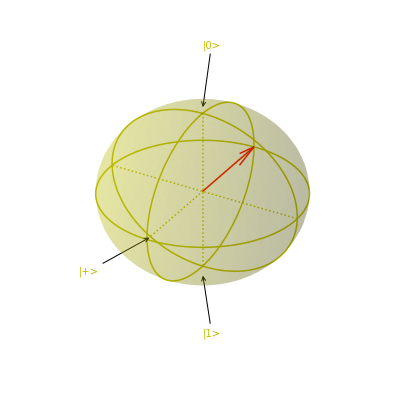

qubit 2
T  : |0|1|
          
q0 : -X-H-

T  : |0|1|

Additional result types: StateVector
Matrix:
[[ 0.70710678+0.j]
 [-0.70710678+0.j]]
 
State Vector: |psi> = sqrt( [0.5] ) |0> + ( sqrt( [0.5] )) e^i [1.] pi |1>
 


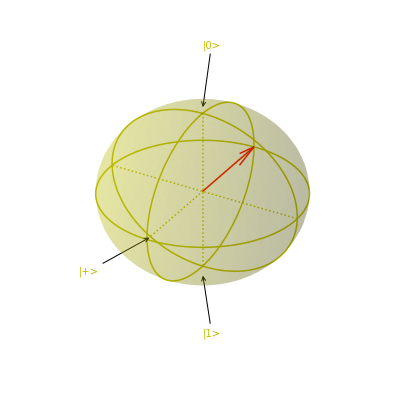

In [304]:
#single circuit
qc=Circuit()
qc=qc.x([0,1]).h([0,1])

param1=0.2
param2=0.4

#separate qubit circuits
qc1=Circuit()
qc2=Circuit()
qc1=qc1.x(0).h(0)
qc2=qc2.x(0).h(0)

print('full circuit')
print(qc)
print('Now print individual qubits circuit')
print('qubit 1')
draw_circuit(qc1)
print('qubit 2')
draw_circuit(qc2)

In [305]:
#single circuit
qc=qc.rz(0,2*-param1*objective[0,0]).rz(1,2*-param1*objective[1,1])
#separate qubit circuits
qc1=qc1.rz(0,-2*param1*objective[0,0])
qc2=qc2.rz(0,-2*param1*objective[1,1])

In [306]:
print(qc)

T  : |0|1|   2    |
                   
q0 : -X-H-Rz(0.4)--
                   
q1 : -X-H-Rz(-0.8)-

T  : |0|1|   2    |


T  : |0|1|   2   |
                  
q0 : -X-H-Rz(0.4)-

T  : |0|1|   2   |

Additional result types: StateVector
Matrix:
[[ 0.69301172-0.14048043j]
 [-0.69301172-0.14048043j]]
 
State Vector: |psi> = sqrt( [0.5] ) |0> + ( sqrt( [0.5] )) e^i [-0.87267605] pi |1>
 


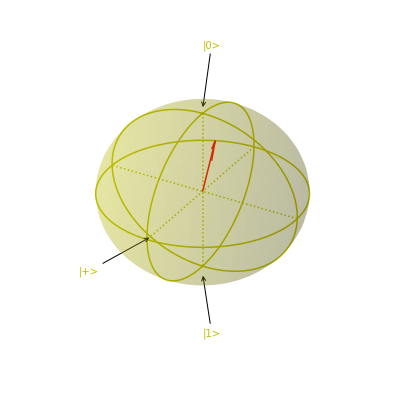

In [307]:
draw_circuit(qc1)

T  : |0|1|   2    |
                   
q0 : -X-H-Rz(-0.8)-

T  : |0|1|   2    |

Additional result types: StateVector
Matrix:
[[ 0.65128847+0.27536035j]
 [-0.65128847+0.27536035j]]
 
State Vector: |psi> = sqrt( [0.5] ) |0> + ( sqrt( [0.5] )) e^i [0.74535209] pi |1>
 


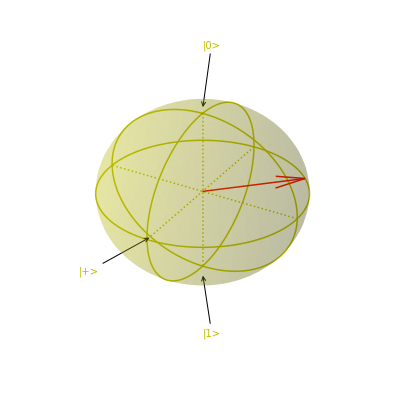

In [308]:
draw_circuit(qc2)

In [309]:
qc=qc.rx(0,2*param2).rx(1,2*param2)
qc1=qc1.rx(0,2*param2)
qc2=qc2.rx(0,2*param2)


In [310]:
print(qc)

T  : |0|1|   2    |   3   |
                           
q0 : -X-H-Rz(0.4)--Rx(0.8)-
                           
q1 : -X-H-Rz(-0.8)-Rx(0.8)-

T  : |0|1|   2    |   3   |


T  : |0|1|   2   |   3   |
                          
q0 : -X-H-Rz(0.4)-Rx(0.8)-

T  : |0|1|   2   |   3   |

Additional result types: StateVector
Matrix:
[[ 0.58360041+0.14048043j]
 [-0.69301172-0.39926252j]]
 
State Vector: |psi> = sqrt( [0.36032419] ) |0> + ( sqrt( [0.63967581] )) e^i [-0.90881658] pi |1>
 


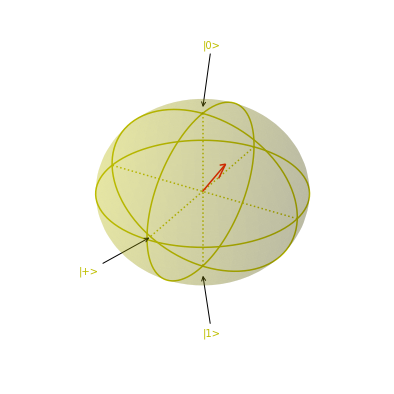

In [311]:
draw_circuit(qc1)

T  : |0|1|   2    |   3   |
                           
q0 : -X-H-Rz(-0.8)-Rx(0.8)-

T  : |0|1|   2    |   3   |

Additional result types: StateVector
Matrix:
[[ 0.70710678+0.50724736j]
 [-0.49264604+0.j        ]]
 
State Vector: |psi> = sqrt( [0.75729988] ) |0> + ( sqrt( [0.24270012] )) e^i [0.80192224] pi |1>
 


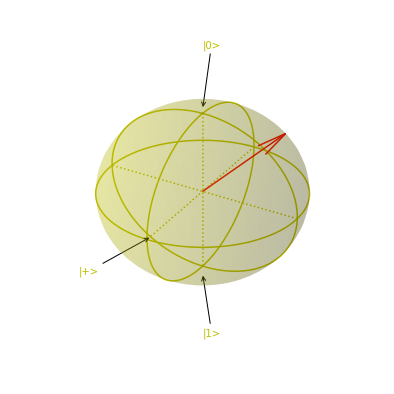

In [312]:
draw_circuit(qc2)

In [313]:
print(qc)

T  : |0|1|   2    |   3   |
                           
q0 : -X-H-Rz(0.4)--Rx(0.8)-
                           
q1 : -X-H-Rz(-0.8)-Rx(0.8)-

T  : |0|1|   2    |   3   |


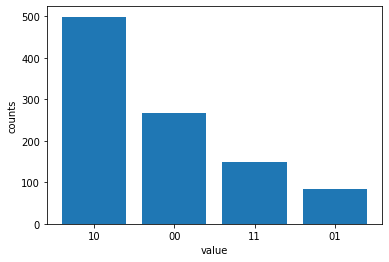

In [321]:
device = LocalSimulator()
result = device.run(qc, shots=1000).result()
counts = result.measurement_counts
plt.bar(counts.keys(), counts.values());
plt.xlabel('value');
plt.ylabel('counts');
plt.show()

## Effect of engantling qubits with ZZ gates

In [322]:
objective=np.array([[-1,-1],[0,2]])
eq=matrix_to_polynomial(objective)

-1x₀²+2x₁²-1x₀x₁


In [384]:
qc=Circuit()
qc=qc.x([0,1]).h([0,1])

param1=0.3
param2=0.3


qc=qc.rz(0,-2*param1*objective[0,0])
qc=qc.rz(1,-2*param1*objective[1,1])
qc=qc.zz(0,1,2*param1*objective[0,1])

qc=qc.rx(0,2*param2).rx(1,2*param2)
print(qc)

T  : |0|1|   2    |   3    |   4   |
                                    
q0 : -X-H-Rz(0.6)--ZZ(-0.6)-Rx(0.6)-
                   |                
q1 : -X-H-Rz(-1.2)-ZZ(-0.6)-Rx(0.6)-

T  : |0|1|   2    |   3    |   4   |


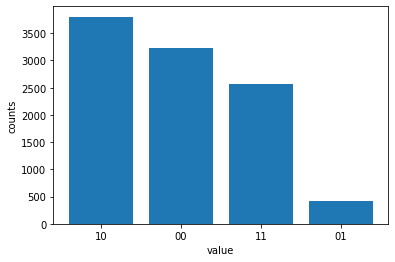

In [413]:
device = LocalSimulator()
result = device.run(qc, shots=10000).result()
counts = result.measurement_counts
plt.bar(counts.keys(), counts.values());
plt.xlabel('value');
plt.ylabel('counts');
plt.show()

### Plotting cost of bqm equations

In [423]:
def plot_bqm_cost(Q):
    x=[]
    y=[]
    n=len(Q)
    input_var=list(range(0,n**2))
    solution=np.zeros(n**2)
    for i in input_var:
        array = format(i, "02b")
        #array=str(int(str(i),2))
        result=sum_energy(Q,array)
        print(i,array,result)
        x.append(array)
        y.append(result)
    plt.bar(x,y)
    plt.show()
    index=np.argsort(y)
    print('prefered sequence of probabilities')
    for i in index:
        print(x[i],y[i])
    

-1x₀²+2x₁²-1x₀x₁
0 00 0
1 01 2
2 10 -1
3 11 0


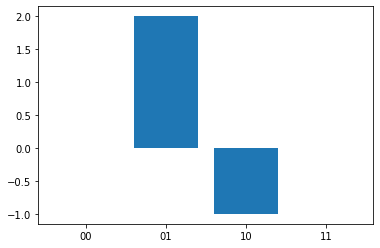

prefered sequence of probabilities
10 -1
00 0
11 0
01 2


In [424]:
objective=np.array([[-1,-1],[0,2]])
eq=matrix_to_polynomial(objective)
plot_bqm_cost(objective)


## Evaluating the effect of parameters

In [437]:
objective=np.array([[-1,-1],[0,2]])
eq=matrix_to_polynomial(objective)

-1x₀²+2x₁²-1x₀x₁


In [447]:
def param_tuning_example(c0,c1,c01, param1, param):
    qc=Circuit()
    qc=qc.x([0,1]).h([0,1])

    qc=qc.rz(0,-2*param1*c0)
    qc=qc.rz(1,-2*param1*c1)

    qc=qc.zz(0,1,2*param1*c01)

    qc=qc.rx(0,2*param2).rx(1,2*param2)
    qc.state_vector()
    device = LocalSimulator()
    result = device.run(qc, shots=0).result()
    counts = result.measurement_counts
    return(result,counts)


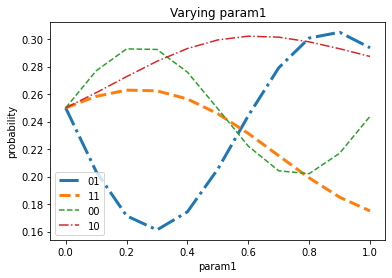

In [475]:
x1=[-6,-5.5,-5,-4.5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0, 0.5,1,1.5,2,2.5,3,3.5,4, 4.5, 5, 5.5, 6]
x2=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

# set x
x=x2

prob_00=[]
prob_01=[]
prob_10=[]
prob_11=[]

c_0=objective[0,0]
c_1=objective[1,1]
c_01=objective[0,1]

#param1=0.5
param2=0.1

for param1 in(x):
    result, counts=param_tuning_example(c_0, c_1, c_01, param1, param2)

    prob_00.append(abs(result.values[0][0])**2)
    prob_01.append(abs(result.values[0][1])**2)
    prob_10.append(abs(result.values[0][2])**2)
    prob_11.append(abs(result.values[0][3])**2)

plt.plot(x,prob_01,'-.',label='01',linewidth=3.0)
plt.plot(x,prob_11,'--',label='11',linewidth=3.0)
plt.plot(x,prob_00,'--',label='00')
plt.plot(x,prob_10,'-.',label='10')

plt.title("Varying param1")
plt.xlabel("param1")
plt.ylabel("probability")
plt.legend()
plt.show()

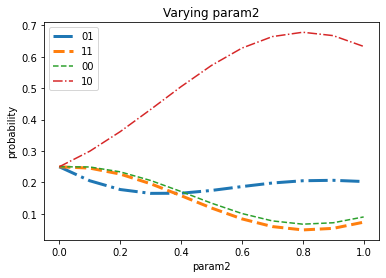

In [476]:
x1=[-6,-5.5,-5,-4.5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0, 0.5,1,1.5,2,2.5,3,3.5,4, 4.5, 5, 5.5, 6]
x2=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

# set x
x=x2

prob_00=[]
prob_01=[]
prob_10=[]
prob_11=[]

c_0=objective[0,0]
c_1=objective[1,1]
c_01=objective[0,1]

param1=0.5
#param2=0.3

for param2 in(x):
    result, counts=param_tuning_example(c_0, c_1, c_01, param1, param2)

    prob_00.append(abs(result.values[0][0])**2)
    prob_01.append(abs(result.values[0][1])**2)
    prob_10.append(abs(result.values[0][2])**2)
    prob_11.append(abs(result.values[0][3])**2)

plt.plot(x,prob_01,'-.',label='01',linewidth=3.0)
plt.plot(x,prob_11,'--',label='11',linewidth=3.0)
plt.plot(x,prob_00,'--',label='00')
plt.plot(x,prob_10,'-.',label='10')

plt.title("Varying param2")
plt.xlabel("param2")
plt.ylabel("probability")
plt.legend()
plt.show()

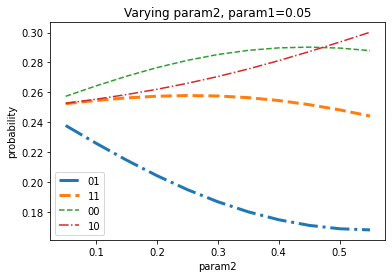

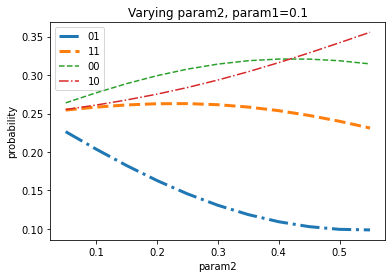

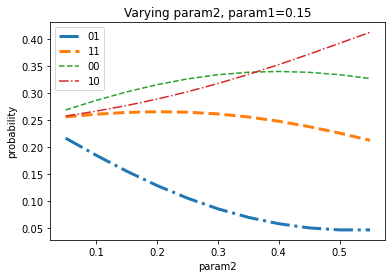

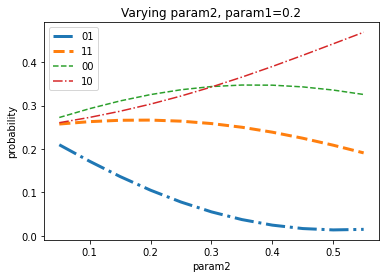

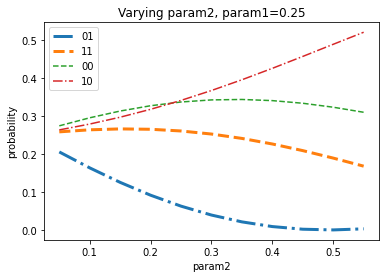

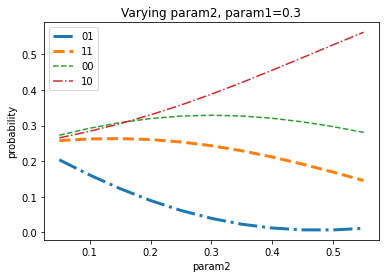

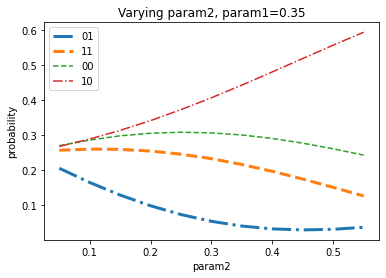

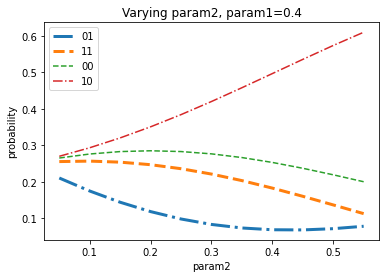

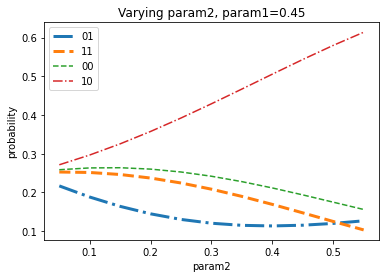

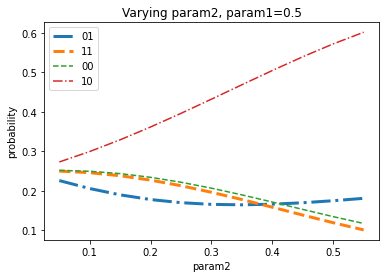

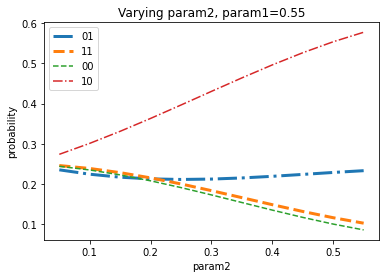

In [456]:
x1=[-6,-5.5,-5,-4.5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0, 0.5,1,1.5,2,2.5,3,3.5,4, 4.5, 5, 5.5, 6]
x2=[0.05, 0.1, 0.15, 0.2, 0.25, 0.3,0.35, 0.4, 0.45, 0.5, 0.55]

# set x
x=x2

c_0=objective[0,0]
c_1=objective[1,1]
c_01=objective[0,1]

#param1=0.15
#param2=0.3
for param1 in (x2):
    prob_00=[]
    prob_01=[]
    prob_10=[]
    prob_11=[]
    for param2 in(x):
        result, counts=param_tuning_example(c_0, c_1, c_01, param1, param2)

        prob_00.append(abs(result.values[0][0])**2)
        prob_01.append(abs(result.values[0][1])**2)
        prob_10.append(abs(result.values[0][2])**2)
        prob_11.append(abs(result.values[0][3])**2)

    plt.plot(x,prob_01,'-.',label='01',linewidth=3.0)
    plt.plot(x,prob_11,'--',label='11',linewidth=3.0)
    plt.plot(x,prob_00,'--',label='00')
    plt.plot(x,prob_10,'-.',label='10')

    plt.title("Varying param2, param1="+str(param1))
    plt.xlabel("param2")
    plt.ylabel("probability")
    plt.legend()
    plt.show()

### Check results with updated parameters

In [469]:
qc=Circuit()
qc=qc.x([0,1]).h([0,1])

param1=0.5
param2=0.2


qc=qc.rz(0,-2*param1*objective[0,0])
qc=qc.rz(1,-2*param1*objective[1,1])
qc=qc.zz(0,1,2*param1*objective[0,1])

qc=qc.rx(0,2*param2).rx(1,2*param2)
print(qc)

T  : |0|1|  2   |  3   |   4   |
                                
q0 : -X-H-Rz(1)--ZZ(-1)-Rx(0.4)-
                 |              
q1 : -X-H-Rz(-2)-ZZ(-1)-Rx(0.4)-

T  : |0|1|  2   |  3   |   4   |


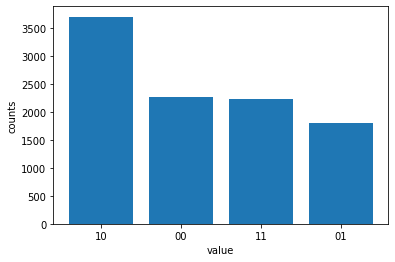

In [472]:
device = LocalSimulator()
result = device.run(qc, shots=10000).result()
counts = result.measurement_counts
plt.bar(counts.keys(), counts.values());
plt.xlabel('value');
plt.ylabel('counts');
plt.show()

In [ ]:
## Varying coupling terms to see the effect

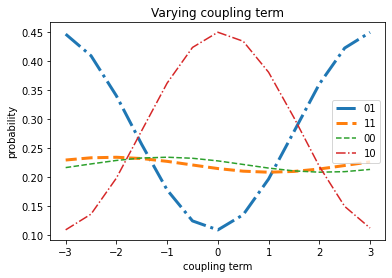

In [478]:
#x1=[-6,-5.5,-5,-4.5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0, 0.5,1,1.5,2,2.5,3,3.5,4, 4.5, 5, 5.5, 6]
x1=[-3,-2.5,-2,-1.5,-1,-0.5,0, 0.5,1,1.5,2,2.5,3]
x2=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

# set x
x=x1

prob_00=[]
prob_01=[]
prob_10=[]
prob_11=[]

c_0=objective[0,0]
c_1=objective[1,1]
#c_01=objective[0,1]

param1=0.5
param2=0.2

for c_01 in(x1):
    result, counts=param_tuning_example(c_0, c_1, c_01, param1, param2)

    prob_00.append(abs(result.values[0][0])**2)
    prob_01.append(abs(result.values[0][1])**2)
    prob_10.append(abs(result.values[0][2])**2)
    prob_11.append(abs(result.values[0][3])**2)
    
plt.plot(x,prob_01,'-.',label='01',linewidth=3.0)
plt.plot(x,prob_11,'--',label='11',linewidth=3.0)
plt.plot(x,prob_00,'--',label='00')
plt.plot(x,prob_10,'-.',label='10')

plt.title("Varying coupling term")
plt.xlabel("coupling term")
plt.ylabel("probability")
plt.legend()
plt.show()

    

In [481]:
#original objective function
objective=np.array([[-1,-1],[0,2]])
eq=matrix_to_polynomial(objective)

-1x₀²+2x₁²-1x₀x₁


-1x₀²+2x₁²
when coupling term is  0
0 00 0
1 01 2
2 10 -1
3 11 1


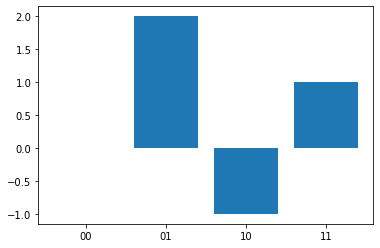

prefered sequence of probabilities
10 -1
00 0
11 1
01 2


In [486]:
#Checking behavior of varyig coupling term to validate the varying coupling term plot above
c_01=0
objective[0,1]=c_01
eq=matrix_to_polynomial(objective)
print('when coupling term is ',objective[0,1])
plot_poly_results(objective)

In [ ]:
# Next we will implement QAOA

## Creating a simple example of a Quantum Approximate Optimization Algorithm

In [507]:
objective=np.array([[1,-2,1,-1,-3,5],[0,2,-1,-1,2,-1],[0,0,3,3,-3,-3], [0,0,0,1,-2,2],[0,0,0,0,1,3],[0,0,0,0,0,2]])
eq=matrix_to_polynomial(objective)

+1x₀²+2x₁²+3x₂²+1x₃²+1x₄²+2x₅²-2x₀x₁+1x₀x₂-1x₀x₃-3x₀x₄+5x₀x₅-1x₁x₂-1x₁x₃+2x₁x₄-1x₁x₅+3x₂x₃-3x₂x₄-3x₂x₅-2x₃x₄+2x₃x₅+3x₄x₅


[[ 1 -2  1 -1 -3  5]
 [ 0  2 -1 -1  2 -1]
 [ 0  0  3  3 -3 -3]
 [ 0  0  0  1 -2  2]
 [ 0  0  0  0  1  3]
 [ 0  0  0  0  0  2]]
+1x₀²+2x₁²+3x₂²+1x₃²+1x₄²+2x₅²-2x₀x₁+1x₀x₂-1x₀x₃-3x₀x₄+5x₀x₅-1x₁x₂-1x₁x₃+2x₁x₄-1x₁x₅+3x₂x₃-3x₂x₄-3x₂x₅-2x₃x₄+2x₃x₅+3x₄x₅
valid values -32.0 to 32.0
from lowest to highest value
input (cost) count
-----  ----- -----
100110(-3) 28
110110(-2) 28
100010(-1) 27
101010(0) 20
000000(0) 28
110100(0) 20
000110(0) 23
001010(1) 26
000010(1) 26
100000(1) 24
000100(1) 34
111010(1) 23
110000(1) 23
111110(1) 23
100100(1) 18
110010(1) 30
101110(1) 30
001001(2) 31
000001(2) 23
010000(2) 25
011001(2) 24
010100(2) 36
010110(3) 29
001011(3) 33
001000(3) 19
001110(3) 21
010001(3) 24
111000(4) 23
011000(4) 27
011010(4) 31
011110(5) 31
010101(5) 21
000101(5) 23
101000(5) 22
011011(5) 25
010010(5) 31
111100(6) 20
000011(6) 28
001100(7) 24
011101(7) 23
001111(7) 27
111011(7) 20
011100(7) 26
000111(7) 30
110001(7) 17
101011(7) 25
111001(7) 25
110101(8) 23
101100(8) 27
001101(8) 25
01111

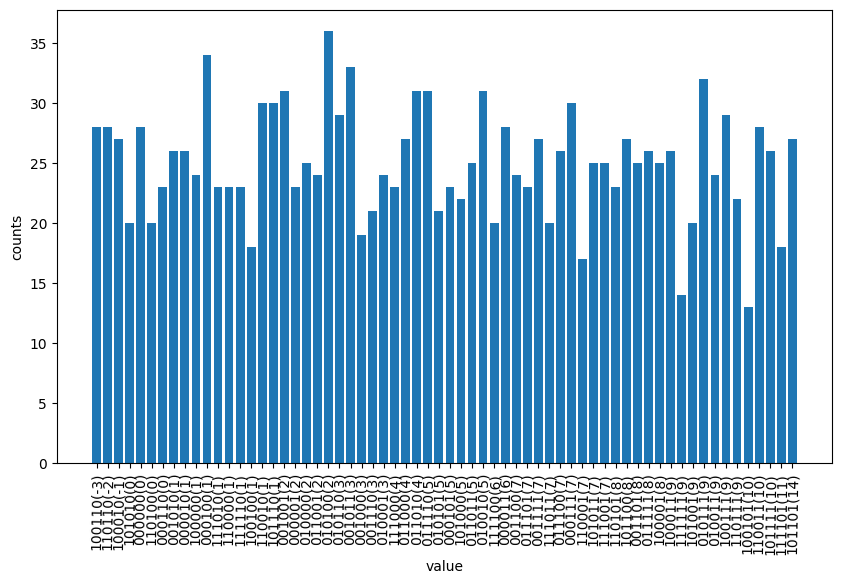

In [282]:
Qubits=len(objective)
qc, len_r1, q_start=multi_qubit_polynomial(Qubits, objective)
device = LocalSimulator()
result = device.run(qc, shots=25*max_val).result()
counts = result.measurement_counts
plot_results_mc(counts, Qubits)

0.075 0.034999999999999996 -3 3


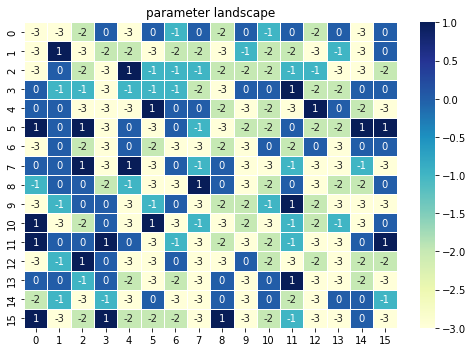

In [584]:
#Optimze Params
param1=np.array([0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65, 0.7, 0.75, 0.8])/10
param2=param1

ideal_param1, ideal_param2, lowest_energy, lowest_count=param_optimizer(param1, param2, objective,20)
print(ideal_param1, ideal_param2, lowest_energy, lowest_count)

Solution: 100110 Energy: -3 Qty Sampled 226


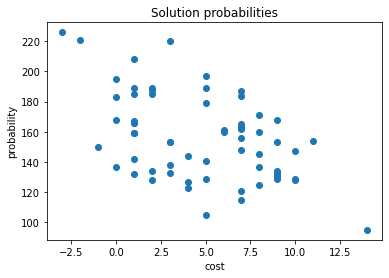

In [591]:
solution,energy,quantity=optimize_bqm([ideal_param1], [ideal_param2], objective, 10000)
print('Solution:',solution, 'Energy:',energy, 'Qty Sampled',quantity)

In [ ]:
--------------------------------------- end ----------------------------------